In [322]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy
import seaborn as sns

In [309]:
# Import data

example_auditory = 'C:/Users/Conor/Documents/Imaging_Data/Two-Photon/Psilocybin_Project/Evoked_Cohort_Mice/ID184/12052022_GCaMP6s_ID184_psilo/TSeries-01012009-0054-028/suite2p/plane0/cells.pkl'
post_psilo = 'C:/Users/Conor/Documents/Imaging_Data/Two-Photon/Psilocybin_Project/Evoked_Cohort_Mice/ID184/12052022_GCaMP6s_ID184_psilo/TSeries-01012009-0054-029/suite2p/plane0/cells.pkl'

with open(example_auditory, 'rb') as f:
    example_auditory = pickle.load(f)

with open(post_psilo, 'rb') as f:
    post_psilo = pickle.load(f)

INPUT_DESIRED_CELL = 1



In [310]:
# EXTRACT INFORMATION ABOUT STIMULUS PARADIGM



cell_ID = example_auditory[INPUT_DESIRED_CELL]
cell = cell_ID['traces']
nfreq = list(cell_ID['traces'].keys())  # Which sound frequencies were presented (Hz)?
nInt = list(cell_ID['traces'][nfreq[0]].keys()) # What intensities were presented (dB)?
ntrial = list(cell_ID['traces'][nfreq[0]][nInt[0]].keys()) # How many trials for each condition? 
print("Conditions:",nfreq, nInt, ntrial)

# In this case, there should be 12 frequencies at four intensities (48 conditions), with ten repeats of each. 
# Each condition contains a 15-frame vector of that cell's trial's relative fluorescence for that trial. 

matrix = np.array([[[cell[i][j][k] for k in ntrial] for j in nInt] for i in nfreq])
print("The shape of this matrix is:", matrix.shape)

# Average the matrix across the trials axis, so that we have one mean response for each frequency intensity combination. 
matrix_av = matrix.mean(axis=2)

# Reshape the matrix so that the baseline period mean is subtracted from the response period.  
normalized_matrix = matrix_av[:,:,5:].mean(axis=-1) - matrix_av[:,:,:5].mean(axis=-1)

Conditions: [4364, 5371, 6612, 8140, 10020, 12335, 15184, 18691, 23009, 28324, 34867, 42922] [35, 50, 65, 80] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
The shape of this matrix is: (12, 4, 10, 15)


In [311]:
matrix_frequency = []
matrix_intensity = []

for key in example_auditory.keys():
    cell_ID = example_auditory[key]
    cell0 = cell_ID['traces']
    nfreq = list(cell_ID['traces'].keys())
    nInt = list(cell_ID['traces'][nfreq[0]].keys())
    ntrial = list(cell_ID['traces'][nfreq[0]][nInt[0]].keys())

    matrix = np.array([[[cell0[i][j][k] for k in ntrial] for j in nInt] for i in nfreq])
        # Average the matrix across trials
    matrix_av = matrix.mean(axis=2)

    # Reshape the matrix so that the baseline mean is subtracted from the mean of the response.  
    matrix_res = matrix_av[:,:,5:].mean(axis=-1) - matrix_av[:,:,:5].mean(axis=-1)

    # Runs SVD on the reshaped matrix, calculates the percentage variance explained.  If it is below threshold, moves onto next iteration.
    U, S, Vt = np.linalg.svd(matrix_res)
    S = S**2/(S**2).sum()

    # matrix_all.append(U[:,0].reshape(-1,1) @ Vt[0,:].reshape(1,-1))
    matrix_frequency.append(np.abs(U[:,0]))
    matrix_intensity.append(np.abs(Vt[:,0]))

matrix_frequency = np.array(matrix_frequency)
matrix_intensity = np.array(matrix_intensity)

print(matrix_frequency.shape)
print(matrix_intensity.shape)

(278, 12)
(278, 4)


In [312]:
matrix_frequency_psilo = []
matrix_intensity_psilo = []

for key in post_psilo.keys():
    cell_ID = post_psilo[key]
    cell0 = cell_ID['traces']
    nfreq = list(cell_ID['traces'].keys())
    nInt = list(cell_ID['traces'][nfreq[0]].keys())
    ntrial = list(cell_ID['traces'][nfreq[0]][nInt[0]].keys())

    matrix = np.array([[[cell0[i][j][k] for k in ntrial] for j in nInt] for i in nfreq])
        # Average the matrix across trials
    matrix_av = matrix.mean(axis=2)

    # Reshape the matrix so that the baseline mean is subtracted from the mean of the response.  
    matrix_res = matrix_av[:,:,5:].mean(axis=-1) - matrix_av[:,:,:5].mean(axis=-1)

    # Runs SVD on the reshaped matrix, calculates the percentage variance explained.  If it is below threshold, moves onto next iteration.
    U, S, Vt = np.linalg.svd(matrix_res)
    S = S**2/(S**2).sum()

    # matrix_all.append(U[:,0].reshape(-1,1) @ Vt[0,:].reshape(1,-1))
    matrix_frequency_psilo.append(np.abs(U[:,0]))
    matrix_intensity_psilo.append(np.abs(Vt[:,0]))

matrix_frequency_psilo = np.array(matrix_frequency_psilo)
matrix_intensity_psilo = np.array(matrix_intensity_psilo)

print(matrix_frequency_psilo.shape)
print(matrix_intensity_psilo.shape)

(373, 12)
(373, 4)


In [313]:
best_frequency = np.argmax(matrix_frequency, axis=1)
best_frequency_psilo = np.argmax(matrix_frequency_psilo, axis=1)

best_frequency = pd.Series(best_frequency)
best_frequency_psilo = pd.Series(best_frequency_psilo)

counts = best_frequency.value_counts(normalize=True)
counts_psilo = best_frequency_psilo.value_counts(normalize=True)



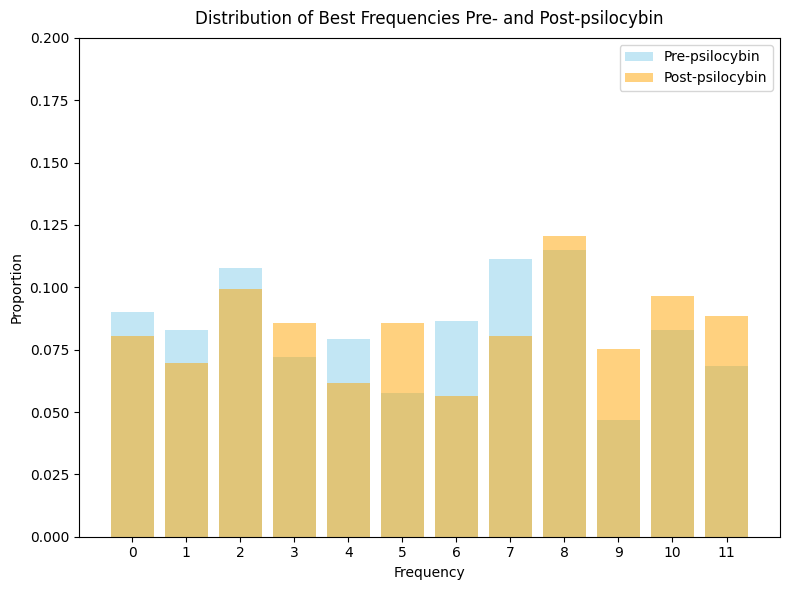

In [317]:
# Create a bar plot comparing the two measures
plt.figure(figsize=(8, 6))
plt.bar(counts.index, counts.values, color='skyblue', alpha=0.5, label='Pre-psilocybin')
plt.bar(counts_psilo.index, counts_psilo.values, color='orange', alpha=0.5, label='Post-psilocybin')
plt.xlabel('Frequency')
plt.ylabel('Proportion')
plt.title('Distribution of Best Frequencies Pre- and Post-psilocybin',pad=10)
plt.xticks(counts.index)
plt.ylim(0,0.20)
plt.legend()
plt.tight_layout()
plt.show()

In [315]:
# Calculate the KL divergence:

kl_divergence = entropy(counts, counts_psilo)

print(f"KL Divergence: {kl_divergence}")


KL Divergence: 0.002700727106847392


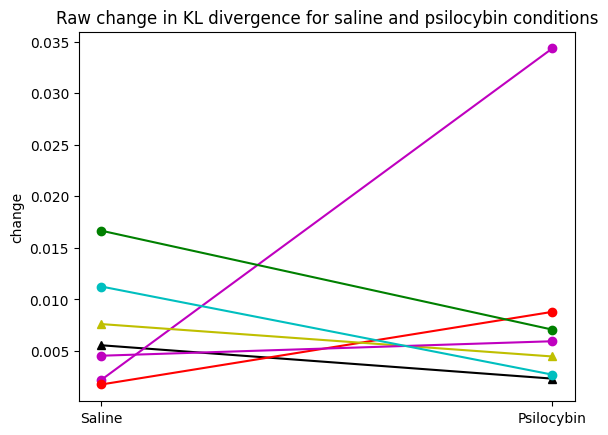

In [320]:
ID276 = [0.005548591479,0.002313237465]
ID269 = [0.002194583197,0.03433263743]
ID251 = [0.001744669732,0.008787783663]
ID239 = [0.007602127317,0.004462393088]
ID237 = [0.01665985358,0.007067290411]
ID186 = [0.004533475891,0.005937478719]
ID184 = [0.01124557508,0.002700727107]
line1 = plt.plot(ID276,'k^-',label='276')
line2 = plt.plot(ID269,'mo-',label='269')
line3 = plt.plot(ID251,'ro-',label='251')
line4 = plt.plot(ID239,'y^-',label='239')
line5 = plt.plot(ID237,'go-',label='237')
line6 = plt.plot(ID186,'mo-',label='186')
line7 = plt.plot(ID184,'co-',label='184')


labels = ("Saline","Psilocybin")
plt.xticks(np.arange(2), labels)
plt.ylabel("change")
plt.title("Raw change in KL divergence for saline and psilocybin conditions")

plt.show()

C:\Users\Conor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


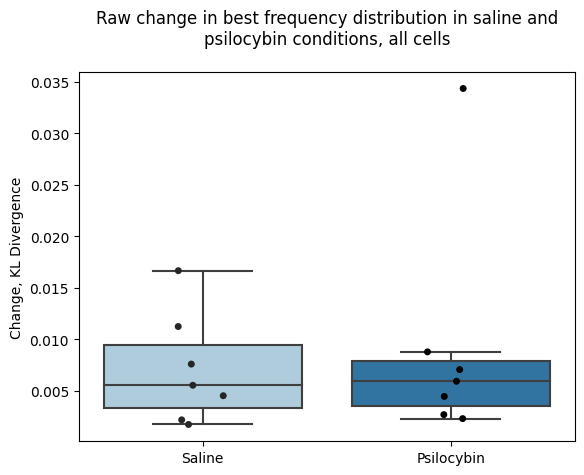

In [328]:
decon_perc_saline = pd.DataFrame([0.01124557508,0.004533475891,0.01665985358,0.007602127317,0.001744669732,0.002194583197,0.005548591479])
decon_perc_psilo = pd.DataFrame([0.002700727107,0.005937478719,0.007067290411,0.004462393088,0.008787783663,0.03433263743,0.002313237465])

df_decon_perc = pd.DataFrame(columns=['Saline','Psilocybin'])

df_decon_perc['Saline'] = decon_perc_saline
df_decon_perc['Psilocybin'] = decon_perc_psilo
sns.set_palette("Paired")
ax = sns.boxplot(data=df_decon_perc,showfliers=False)
sns.stripplot(data=df_decon_perc,color='black')

plt.ylabel("Change, KL Divergence")
plt.title("Raw change in best frequency distribution in saline and\npsilocybin conditions, all cells",pad=20)


plt.show()